https://www.analyticsvidhya.com/blog/2019/01/neural-machine-translation-keras/

In [3]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [4]:
language_data = pd.read_csv("Indonesian_palembang.csv", encoding = 'iso-8859-1')
language_data

indonesia      palembang
0      aba-aba        Aba-aba
1      aba-aba  Ancang-ancang
2         abad           Abad
3        abadi          Abadi
4        abadi          Kekal
...        ...            ...
2075   wilayah         daerah
2076   wilayah        wilayah
2077     zaman          zaman
2078     zaman       empai ni
2079      zona           zona

[2080 rows x 2 columns]

In [5]:
indonesia_text = language_data['indonesia'].values
palembang_text = language_data['palembang'].values
len(indonesia_text), len(palembang_text)

(2080, 2080)

In [6]:
#to lower case
indonesia_text_ = [x.lower() for x in indonesia_text]
palembang_text_ = [x.lower() for x in palembang_text]

In [7]:
# removing the stating and ending whitespaces
indonesia_text_ = [x.strip() for x in indonesia_text_]
palembang_text_ = [x.strip() for x in palembang_text_]

In [8]:
indonesia_text_ = pd.DataFrame(indonesia_text_, columns = ["indonesia"])
palembang_text_ = pd.DataFrame(palembang_text_, columns = ["palembang"])

In [9]:
gabungan = pd.concat ([indonesia_text_, palembang_text_], axis = 1)
gabungan

indonesia      palembang
0      aba-aba        aba-aba
1      aba-aba  ancang-ancang
2         abad           abad
3        abadi          abadi
4        abadi          kekal
...        ...            ...
2075   wilayah         daerah
2076   wilayah        wilayah
2077     zaman          zaman
2078     zaman       empai ni
2079      zona           zona

[2080 rows x 2 columns]

In [38]:
ind_pal = gabungan.values
ind_pal

array([['abaaba', 'abaaba'],
       ['abaaba', 'ancangancang'],
       ['abad', 'abad'],
       ...,
       ['zaman', 'zaman'],
       ['zaman', 'empai ni'],
       ['zona', 'zona']], dtype=object)

In [39]:
# Remove punctuation
ind_pal[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ind_pal[:,0]]
ind_pal[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ind_pal[:,1]]

In [40]:
ind_pal

array([['abaaba', 'abaaba'],
       ['abaaba', 'ancangancang'],
       ['abad', 'abad'],
       ...,
       ['zaman', 'zaman'],
       ['zaman', 'empai ni'],
       ['zona', 'zona']], dtype=object)

In [41]:
# convert text to lowercase
for i in range(len(ind_pal)):
    ind_pal[i,0] = ind_pal[i,0].lower()
    ind_pal[i,1] = ind_pal[i,1].lower()

ind_pal

array([['abaaba', 'abaaba'],
       ['abaaba', 'ancangancang'],
       ['abad', 'abad'],
       ...,
       ['zaman', 'zaman'],
       ['zaman', 'empai ni'],
       ['zona', 'zona']], dtype=object)

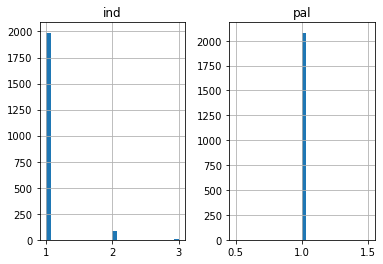

In [43]:
# empty lists
pal_l = []
ind_l = []

# populate the lists with sentence lengths
for i in ind_pal[:,0]:
      pal_l.append(len(i.split()))

for i in ind_pal[:,1]:
      ind_l.append(len(i.split()))

length_df = pd.DataFrame({'pal':pal_l, 'ind':ind_l})

length_df.hist(bins = 30)
plt.show()

In [44]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [52]:
# prepare pal tokenizer
pal_tokenizer = tokenization(ind_pal[:, 0])
pal_vocab_size = len(pal_tokenizer.word_index) + 1

pal_length = 8
print('palembang Vocabulary Size: %d' % pal_vocab_size)

palembang Vocabulary Size: 1313


In [53]:
# prepare ind tokenizer
ind_tokenizer = tokenization(ind_pal[:, 1])
ind_vocab_size = len(ind_tokenizer.word_index) + 1

ind_length = 8
print('Indo Vocabulary Size: %d' % ind_vocab_size)

Indo Vocabulary Size: 1791


In [54]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [55]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(ind_pal, test_size=0.2, random_state = 12)

In [56]:
# prepare training data
trainX = encode_sequences(ind_tokenizer, ind_length, train[:, 1])
trainY = encode_sequences(pal_tokenizer, pal_length, train[:, 0])

# prepare validation data
testX = encode_sequences(ind_tokenizer, ind_length, test[:, 1])
testY = encode_sequences(pal_tokenizer, pal_length, test[:, 0])

In [60]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [61]:
# model compilation
model = define_model(ind_vocab_size, pal_vocab_size, ind_length, pal_length, 512)

In [62]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [63]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30
3/3 [==============================] - 17s 3s/step - loss: 7.1375 - val_loss: 5.5725

Epoch 00001: val_loss improved from inf to 5.57247, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 2/30
3/3 [==============================] - 6s 2s/step - loss: 4.1192 - val_loss: 2.5453

Epoch 00002: val_loss improved from 5.57247 to 2.54526, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 3/30
3/3 [==============================] - 6s 2s/step - loss: 1.7172 - val_loss: 2.1256

Epoch 00003: val_loss improved from 2.54526 to 2.12560, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 4/30
3/3 [==============================] - 8s 3s/step - loss: 1.2074 - val_loss: 1.9466

Epoch 00004: val_loss improved from 2.12560 to 1.94661, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 5/30
3/3 [==============================] - 7s 2s/step - loss: 0.9638 - val_loss: 1.8698

Epoch 00005: val_loss improved from 1.94661 to 1.86979, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 6/30
3/3 [==============================] - 6s 2s/step - loss: 0.9018 - val_loss: 1.8551

Epoch 00006: val_loss improved from 1.86979 to 1.85507, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 7/30
3/3 [==============================] - 6s 2s/step - loss: 0.8920 - val_loss: 1.8506

Epoch 00007: val_loss improved from 1.85507 to 1.85063, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 8/30
3/3 [==============================] - 6s 2s/step - loss: 0.8865 - val_loss: 1.8493

Epoch 00008: val_loss improved from 1.85063 to 1.84930, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 9/30
3/3 [==============================] - 6s 2s/step - loss: 0.8825 - val_loss: 1.8507

Epoch 00009: val_loss did not improve from 1.84930
Epoch 10/30
3/3 [==============================] - 7s 2s/step - loss: 0.8786 - val_loss: 1.8524

Epoch 00010: val_loss did not improve from 1.84930
Epoch 11/30
3/3 [==============================] - 7s 2s/step - loss: 0.8748 - val_loss: 1.8548

Epoch 00011: val_loss did not improve from 1.84930
Epoch 12/30
3/3 [==============================] - 7s 2s/step - loss: 0.8706 - val_loss: 1.8591

Epoch 00012: val_loss did not improve from 1.84930
Epoch 13/30
3/3 [==============================] - 7s 2s/step - loss: 0.8661 - val_loss: 1.8663

Epoch 00013: val_loss did not improve from 1.84930
Epoch 14/30
3/3 [==============================] - 6s 2s/step - loss: 0.8626 - val_loss: 1.8780

Epoch 00014: val_loss did not improve from 1.84930
Epoch 15/30
3/3 [==============================] - 7s 2s/step - loss: 0.8590 - val_loss: 1.8878

Epoch 00015: val

INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 27/30
3/3 [==============================] - 7s 2s/step - loss: 0.8315 - val_loss: 1.8302

Epoch 00027: val_loss improved from 1.83237 to 1.83021, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 28/30
3/3 [==============================] - 7s 2s/step - loss: 0.8281 - val_loss: 1.7963

Epoch 00028: val_loss improved from 1.83021 to 1.79627, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 29/30
3/3 [==============================] - 7s 2s/step - loss: 0.8271 - val_loss: 1.7965

Epoch 00029: val_loss did not improve from 1.79627
Epoch 30/30
3/3 [==============================] - 7s 2s/step - loss: 0.8237 - val_loss: 1.7816

Epoch 00030: val_loss improved from 1.79627 to 1.78162, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


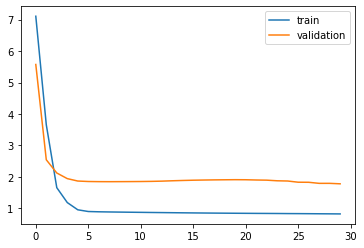

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [65]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\PRAM\Anaconda\lib\site-packages\tensorflow\python\keras\engine\sequential.py:459: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [66]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [67]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], pal_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], pal_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [68]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [70]:
# print x rows randomly
pred_df.sample(30)

actual predicted
70       gerakan          
332        telur          
114        karya          
304    bendungan          
12        kertas          
147        macan          
168        juara          
35         mayat          
62        doktor          
151    keturunan          
94         singa          
327        darah          
156       lelaki          
294      kutukan          
407    kebiasaan          
146       minggu          
129       cahaya          
170   pernyataan          
102         ayah          
280         laci          
189        kakak          
103         mama          
302         buku          
206  kegembiraan          
74           isu          
76         ujung          
20         waktu          
66          alat          
285      program          
319      militer